In [1]:
import swissgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.linear_model import LinearRegression
import datetime
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
ts = swissgrid.grid_data.iloc[:,0] #end user consumption
# ts = ts.resample('1 H').mean()

weather = pd.read_csv('data/weather_data_filtered.csv')
weather['timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather = weather[['timestamp', 'CH_temperature']].set_index('timestamp').sort_index()
weather = weather.tz_localize(None) #drop bad tz information. timestamp is not really UTC since it follow 
# daylight changing times, it is just swiss time -1 hour
weather.index = weather.index + datetime.timedelta(hours=1)
#in this way we dropped TZ info, but we should have matching times between the two series
# the following two cells check that indeed the daylight-saving time switches happen at the same time,
# even though the two data sources use two different conventions to write the time when the switch happens

In [3]:
start_time = weather.index[(weather.index >= ts.index[0]).argmax()] 
#take first weather index which is bigger than ts index
end_time = weather.index[-1]
idx = pd.date_range(start_time, end_time, freq='1 H', tz='Europe/Zurich').tz_localize(None)
SAMPS_DAY = 24

In [4]:
ts = ts.resample('15 T').first().reindex(idx,method='ffill')
weather = weather.resample('1 H').first().reindex(idx, method='ffill')

In [5]:
days = ts.index
# special days
def get_holy(prov):
    h = holidays.Switzerland(prov=prov)
    return [day in h for day in days]
holidays_cantons = pd.DataFrame(data = {prov:get_holy(prov) for prov in holidays.Switzerland.PROVINCES},
             index = days)
#add sundays (hurts MSE)
# holidays_cantons = (holidays_cantons.T | (holidays_cantons.index.dayofweek == 6)).T

cantons = pd.read_csv('data/cantons.csv').set_index('Code')
#magic trick
cantons['Population'] = cantons['Population'].str.extract('([^\[]*)').iloc[:,0].str.split(',').str.join('').astype(np.intp)

holiday_pop = holidays_cantons*cantons['Population']

### autoregressive part

The consumption $L_{hd}$ today at day $d$ and hour $h$ depends on $L_{h-1d}$, $L_{hd-1}$, $L_{hd-7}$

In [6]:
def build_ts_regressor(ts, weather, holiday_pop, fourier_order=4):
    #interact annual pattern like (6)
    week_lag_idx = np.arange(ts.size-SAMPS_DAY*7)
    t = ((
        ts.index[SAMPS_DAY*7:ts.size] - pd.datetime(year=ts.index[0].year, month=1, day=1)
    ).total_seconds()//(60*24*60/SAMPS_DAY)).astype(np.intp)
    samps_year = SAMPS_DAY*7*52
    sins =  np.array([np.sin(2*q*np.pi*(t/samps_year)) for q in range(1, fourier_order+1)]).T
    cosins =np.array([np.cos(2*q*np.pi*(t/samps_year)) for q in range(1, fourier_order+1)]).T
    week_lagged_reg = ts.values[week_lag_idx,None]*np.hstack([np.ones((week_lag_idx.size,1)), sins, cosins])
    
    #interact daily indicators with daily lag (5)
    week_day = ts.index[SAMPS_DAY*7:ts.size].dayofweek
    I = np.eye(7)
    week_day_indicators = np.array([I[i] for i in week_day])
    day_lag_idx = np.arange(SAMPS_DAY*6, ts.size-SAMPS_DAY)
    day_lagged_reg = ts.values[day_lag_idx,None]*week_day_indicators
    
    # hourly lag regressor (7)
    hour_lag_idx = np.arange(SAMPS_DAY*7 - 1, ts.size-1)
    hour_lagged_reg = ts.values[hour_lag_idx][:,None]
    
    #temperature
    weather_reg = weather.values[SAMPS_DAY*7:ts.size]
    
    #special days
    holiday_reg = holiday_pop.sum(axis=1).values[SAMPS_DAY*7:ts.size, None]
    holiday_lagged_reg = holiday_pop.sum(axis=1).values[:ts.size - SAMPS_DAY*7,None]
    
    return np.hstack(
        [
            week_lagged_reg,
            day_lagged_reg,
            hour_lagged_reg,
            weather_reg,
            holiday_reg,
            holiday_lagged_reg
        ]
    )

In [7]:
MAPE_triv = np.mean(np.abs((ts.values[7*SAMPS_DAY-1:-1] - ts.values[7*SAMPS_DAY:]))/ts.values[7*SAMPS_DAY:])
MAPE_triv

0.03861742208541909

In [8]:
reg = build_ts_regressor(ts, weather, holiday_pop)
lr = LinearRegression().fit(reg, ts.values[7*SAMPS_DAY:])

In [9]:
MAPE = np.mean(np.abs((lr.predict(reg) - ts.values[7*SAMPS_DAY:]))/ts.values[7*SAMPS_DAY:])
MAPE

0.027898800503406016

### Moving Average part

We can now add a moving average component to the mix and see if our forecasting imporves. The moving average takes into account previous hour errors and previous week error.
The estimation is done by applying the ordinary linear model, and treating residuals as estimated innovations, and iterating the least square estimation, and innovation estimations.

In [10]:
reg = build_ts_regressor(ts, weather, holiday_pop)
eps = np.zeros_like(ts.values[7*SAMPS_DAY:])
# we drop an additional leading week so the least squares estimation is done
# with all the estimated epsilons, previous week before included.
for c in range(100):
    eps_reg = np.hstack([eps[:-7*SAMPS_DAY,None], eps[6*SAMPS_DAY:-SAMPS_DAY,None]])
    lr = LinearRegression().fit(np.hstack([reg[7*SAMPS_DAY:],eps_reg]), ts.values[14*SAMPS_DAY:])
    eps = ts.values[7*SAMPS_DAY:] - lr.predict(np.hstack([reg, np.vstack([np.zeros([7*SAMPS_DAY,eps_reg.shape[1]]), eps_reg])]))
#     print(c, np.mean(np.abs(eps[7*SAMPS_DAY:]/ts.values[14*SAMPS_DAY:])))

## Multiple Equations

By changing the single regression into 96 individual parameter sets, one for each daily time, we are back to the multiple equations setting described in Clements, Hurn and Li.

In [11]:
reg = build_ts_regressor(ts, weather, holiday_pop)
eps = np.zeros_like(ts.values[7*SAMPS_DAY:])
regressions = [LinearRegression() for i in range(SAMPS_DAY)]

for c in range(100):
    eps_reg = np.hstack([eps[:-7*SAMPS_DAY,None], eps[6*SAMPS_DAY:-SAMPS_DAY,None]])
    for daily_time in range(SAMPS_DAY):
        regressions[daily_time].fit(
            np.hstack(
                [reg[7*SAMPS_DAY+daily_time::SAMPS_DAY],eps_reg[daily_time::SAMPS_DAY]]
            ),
            ts.values[daily_time + 14*SAMPS_DAY::SAMPS_DAY]
        )
        eps[daily_time::SAMPS_DAY] = ts.values[daily_time + 7*SAMPS_DAY::SAMPS_DAY]\
            - regressions[daily_time].predict(
                np.hstack([
                        reg[daily_time::SAMPS_DAY],
                        np.vstack([np.zeros([7*SAMPS_DAY,eps_reg.shape[1]]), eps_reg])[daily_time::SAMPS_DAY]
                ])
            )
    if c % 10 == 0:
        print(c, np.mean(np.abs(eps[7*SAMPS_DAY:]/ts.values[14*SAMPS_DAY:])))

0 0.010257072168687311
10 0.009143034972703185
20 0.00913882409316798
30 0.009138798276510771
40 0.009138806023057118
50 0.009138811520667471
60 0.0091388105843345
70 0.009138810511398919
80 0.009138810583230843
90 0.009138810578694923


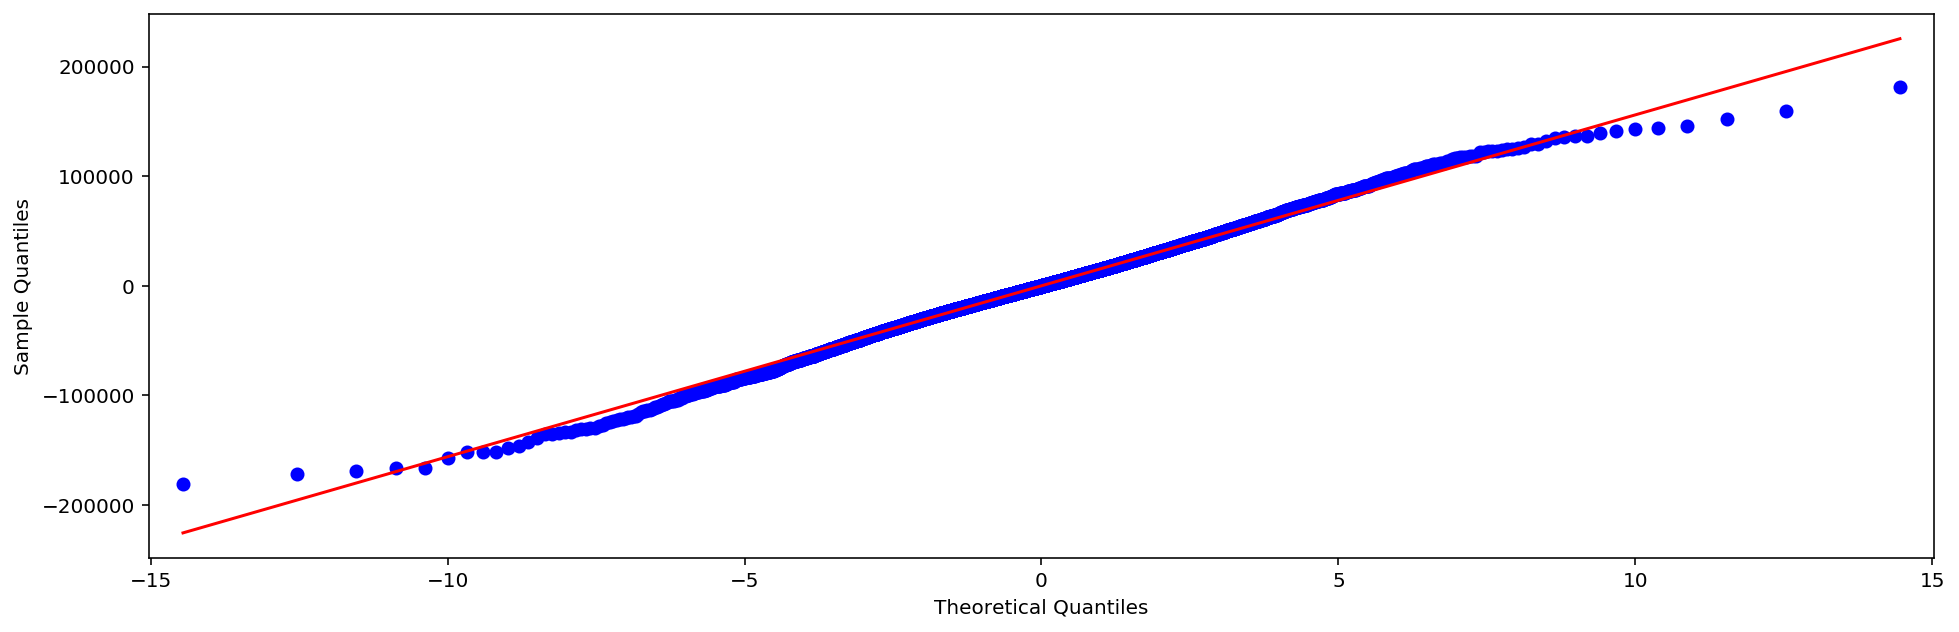

In [12]:
#heavy tailed residuals distribution
sm.graphics.qqplot(eps, line='r', dist=stats.t, distargs=(5,));

## Cross Validation

In [13]:
def test_multiple_eq(ts, weather, holiday_pop):
    #regressor
    reg = build_ts_regressor(ts, weather, holiday_pop)
    eps = np.zeros_like(ts.values[7*SAMPS_DAY:])
    regressions = [LinearRegression() for i in range(SAMPS_DAY)]

    for c in range(100):
        eps_reg = np.hstack([eps[:-7*SAMPS_DAY,None], eps[6*SAMPS_DAY:-SAMPS_DAY,None]])
        for daily_time in range(SAMPS_DAY):
            regressions[daily_time].fit(
                np.hstack(
                    [reg[7*SAMPS_DAY+daily_time:-1:SAMPS_DAY],eps_reg[daily_time:-1:SAMPS_DAY]]
                ),
                ts.values[daily_time + 14*SAMPS_DAY:-1:SAMPS_DAY]
            )
            eps[daily_time::SAMPS_DAY] = ts.values[daily_time + 7*SAMPS_DAY::SAMPS_DAY]\
                - regressions[daily_time].predict(
                    np.hstack([
                            reg[daily_time::SAMPS_DAY],
                            np.vstack([np.zeros([7*SAMPS_DAY,eps_reg.shape[1]]), eps_reg])[daily_time::SAMPS_DAY]
                    ])
)
            eps
    APE = np.abs(eps[-1]/ts.values[-1])
    return APE

In [15]:
import sys
run_length = 10000
tests = 10
apes = []

for test_number in range(tests):
    test_start = test_number*(ts.values.size - run_length)//tests
    APE = test_multiple_eq(ts.iloc[test_start:test_start + run_length],
                     weather.iloc[test_start:test_start + run_length],
                     holiday_pop.iloc[test_start:test_start + run_length])
    print('.', end='')
    if test_number != 0 and test_number % 20 == 0:
        print()
    sys.stdout.flush()
    apes.append(APE)

..........

In [16]:
apes

[0.001978335107097738,
 0.001171484223044473,
 0.002891171337933555,
 0.004438944811636552,
 0.005150354785844235,
 0.00962905125063669,
 0.005181452457734595,
 0.007432864812322249,
 0.004063951826560613,
 0.012626282878382225]